In [1]:
### Install and Set up Kaggle

!pip install kaggle

# Make a .kaggle folder and move the API token there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
### Download Dataset

# Download Dogs vs Cats dataset
!kaggle competitions download -c dogs-vs-cats

# Unzip only the train folder
!unzip -q train.zip -d data/

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
unzip:  cannot find or open train.zip, train.zip.zip or train.zip.ZIP.


In [3]:
from google.colab import files
files.upload()   # isse ek file chooser khulega

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shalinisaurav","key":"b562545a436e584d3f45c4495325d3be"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# 3. Dataset download using Kaggle API

!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 95% 751M/788M [00:07<00:00, 316MB/s]
100% 788M/788M [00:07<00:00, 106MB/s]


In [6]:
# 4. Zip file ko unzip karo (with overwrite safety)

!unzip -o microsoft-catsvsdogs-dataset.zip -d ./cats_vs_dogs

Streaming output truncated to the last 5000 lines.
  inflating: ./cats_vs_dogs/PetImages/Dog/550.jpg  
  inflating: ./cats_vs_dogs/PetImages/Dog/5500.jpg  
  inflating: ./cats_vs_dogs/PetImages/Dog/5501.jpg  
  inflating: ./cats_vs_dogs/PetImages/Dog/5502.jpg  
  inflating: ./cats_vs_dogs/PetImages/Dog/5503.jpg  
  inflating: ./cats_vs_dogs/PetImages/Dog/5504.jpg  
  inflating: ./cats_vs_dogs/PetImages/Dog/5505.jpg  
  inflating: ./cats_vs_dogs/PetImages/Dog/5506.jpg  
  inflating: ./cats_vs_dogs/PetImages/Dog/5507.jpg  
  inflating: ./cats_vs_dogs/PetImages/Dog/5508.jpg  
  inflating: ./cats_vs_dogs/PetImages/Dog/5509.jpg  
  inflating: ./cats_vs_dogs/PetImages/Dog/551.jpg  
  inflating: ./cats_vs_dogs/PetImages/Dog/5510.jpg  
  inflating: ./cats_vs_dogs/PetImages/Dog/5511.jpg  
  inflating: ./cats_vs_dogs/PetImages/Dog/5512.jpg  
  inflating: ./cats_vs_dogs/PetImages/Dog/5513.jpg  
  inflating: ./cats_vs_dogs/PetImages/Dog/5514.jpg  
  inflating: ./cats_vs_dogs/PetImages/Dog/5515.jpg

In [8]:
### Check Dataset is correctly Extracted or not

import os

base_dir = "./cats_vs_dogs/PetImages"
print("Classes:", os.listdir(base_dir))  # Cat, Dog folders dikhna chahiye
print("Total Cats images:", len(os.listdir(os.path.join(base_dir, "Cat"))))
print("Total Dogs images:", len(os.listdir(os.path.join(base_dir, "Dog"))))

Classes: ['Dog', 'Cat']
Total Cats images: 12501
Total Dogs images: 12501


In [9]:
### INSTALL DEPENDENCY

!pip install -q tensorflow matplotlib pillow

In [10]:
### IMPORT LIBRARIES

import os
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [11]:
### DATASET PATH

# Base directory of your dataset
base_dir = '/content/MicrosoftCatsVsDogs'

# Train and validation directories
train_dir = '/content/train'
val_dir = '/content/val'

# Create directories if not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [12]:
!ls /content/

cats_vs_dogs  microsoft-catsvsdogs-dataset.zip	train
kaggle.json   sample_data			val


In [13]:
import os

base_dir = '/content/cats_vs_dogs'  # actual dataset folder
print(os.listdir(base_dir))  # check folder contents

['readme[1].txt', 'PetImages', 'MSR-LA - 3467.docx']


In [14]:
### If Images Are All Together

"""Separate them into cats and dogs subfolders:"""

import os
import shutil

base_dir = '/content/cats_vs_dogs'

# Make sure categories exist
for category in ['cats', 'dogs']:
    cat_path = os.path.join(base_dir, category)
    os.makedirs(cat_path, exist_ok=True)

# Move only image files into their respective folders
for file in os.listdir(base_dir):
    file_path = os.path.join(base_dir, file)

    if os.path.isfile(file_path):  # only move files, skip folders
        file_lower = file.lower()
        if 'cat' in file_lower:
            shutil.move(file_path, os.path.join(base_dir, 'cats', file))
        elif 'dog' in file_lower:
            shutil.move(file_path, os.path.join(base_dir, 'dogs', file))

In [15]:
print(os.listdir(base_dir))

['cats', 'dogs', 'readme[1].txt', 'PetImages', 'MSR-LA - 3467.docx']


In [16]:
### Organize Dataset into train/val folders

# Organize images into train and val (80%-20%)
for category in ['cats', 'dogs']:  # <- use these exact folder names
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

    files = os.listdir(os.path.join(base_dir, category))
    np.random.shuffle(files)

    train_split = int(len(files) * 0.8)
    train_files = files[:train_split]
    val_files = files[train_split:]

    for f in train_files:
        shutil.move(os.path.join(base_dir, category, f), os.path.join(train_dir, category, f))
    for f in val_files:
        shutil.move(os.path.join(base_dir, category, f), os.path.join(val_dir, category, f))

In [17]:
### Remove Corrupted Images

from PIL import Image
import os

def remove_corrupted_images(folder_path):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')  # only check image files
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if not file.lower().endswith(valid_extensions):
                continue  # skip non-image files
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # verify image is not corrupted
            except (IOError, SyntaxError, Image.DecompressionBombError) as e:
                print(f"Removing corrupted image: {file_path} → {e}")
                os.remove(file_path)

# Apply to train and val directories
remove_corrupted_images(train_dir)
remove_corrupted_images(val_dir)

In [18]:
import os
import shutil
import numpy as np
from PIL import Image

base_dir = '/content/cats_vs_dogs'  # your uploaded dataset
train_dir = '/content/train'
val_dir = '/content/val'

# Make sure train/val folders exist
for dir_path in [train_dir, val_dir]:
    os.makedirs(dir_path, exist_ok=True)

categories = ['cats', 'dogs']

# Remove corrupted images and collect valid images
valid_images = {cat: [] for cat in categories}
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

for cat in categories:
    src_path = os.path.join(base_dir, cat)
    os.makedirs(os.path.join(train_dir, cat), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cat), exist_ok=True)

    for file in os.listdir(src_path):
        if not file.lower().endswith(valid_extensions):
            continue  # skip non-image files
        file_path = os.path.join(src_path, file)
        try:
            img = Image.open(file_path)
            img.verify()
            valid_images[cat].append(file)
        except:
            print(f"Removing corrupted file: {file_path}")
            os.remove(file_path)

# Split into train/val and move
for cat in categories:
    files = valid_images[cat]
    np.random.shuffle(files)
    split_idx = int(len(files) * 0.8)
    train_files = files[:split_idx]
    val_files = files[split_idx:]

    for f in train_files:
        shutil.move(os.path.join(base_dir, cat, f), os.path.join(train_dir, cat, f))
    for f in val_files:
        shutil.move(os.path.join(base_dir, cat, f), os.path.join(val_dir, cat, f))

# Check counts
for cat in categories:
    print(f"Train {cat}: {len(os.listdir(os.path.join(train_dir, cat)))}")
    print(f"Val {cat}: {len(os.listdir(os.path.join(val_dir, cat)))}")

Train cats: 0
Val cats: 0
Train dogs: 0
Val dogs: 0


In [19]:
import os

pet_images_dir = '/content/cats_vs_dogs/PetImages'
print(os.listdir(pet_images_dir))

['Dog', 'Cat']


In [20]:
import os
import shutil
import numpy as np
from PIL import Image

# Correct base directory
base_dir = '/content/cats_vs_dogs/PetImages'
train_dir = '/content/train'
val_dir = '/content/val'

# Make train/val folders
for dir_path in [train_dir, val_dir]:
    os.makedirs(dir_path, exist_ok=True)

categories = ['Cat', 'Dog']  # folder names exactly as in PetImages

# Remove corrupted images and collect valid images
valid_images = {cat: [] for cat in categories}
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

for cat in categories:
    src_path = os.path.join(base_dir, cat)
    os.makedirs(os.path.join(train_dir, cat), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cat), exist_ok=True)

    for file in os.listdir(src_path):
        if not file.lower().endswith(valid_extensions):
            continue  # skip non-image files
        file_path = os.path.join(src_path, file)
        try:
            img = Image.open(file_path)
            img.verify()
            valid_images[cat].append(file)
        except:
            print(f"Removing corrupted file: {file_path}")
            os.remove(file_path)

# Split into train/val and move
for cat in categories:
    files = valid_images[cat]
    np.random.shuffle(files)
    split_idx = int(len(files) * 0.8)
    train_files = files[:split_idx]
    val_files = files[split_idx:]

    for f in train_files:
        shutil.move(os.path.join(base_dir, cat, f), os.path.join(train_dir, cat, f))
    for f in val_files:
        shutil.move(os.path.join(base_dir, cat, f), os.path.join(val_dir, cat, f))

# Check counts
for cat in categories:
    print(f"Train {cat}: {len(os.listdir(os.path.join(train_dir, cat)))}")
    print(f"Val {cat}: {len(os.listdir(os.path.join(val_dir, cat)))}")

Removing corrupted file: /content/cats_vs_dogs/PetImages/Cat/666.jpg


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Removing corrupted file: /content/cats_vs_dogs/PetImages/Dog/11702.jpg
Train Cat: 9999
Val Cat: 2500
Train Dog: 9999
Val Dog: 2500


In [21]:
### Data Augmentation

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 19998 images belonging to 4 classes.
Found 5000 images belonging to 4 classes.


In [22]:
### Build Model with Transfer Learning

# Base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Custom classifier
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [23]:
### Train the Model

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10  # You can increase later
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 364s 557ms/step - accuracy: 0.7854 - loss: 0.4566 - val_accuracy: 0.9010 - val_loss: 0.2317
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 324s 519ms/step - accuracy: 0.8715 - loss: 0.2941 - val_accuracy: 0.9118 - val_loss: 0.2080
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 325s 520ms/step - accuracy: 0.8774 - loss: 0.2777 - val_accuracy: 0.9268 - val_loss: 0.1811
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 321s 513ms/step - accuracy: 0.8818 - loss: 0.2717 - val_accuracy: 0.9266 - val_loss: 0.1791
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 328s 524ms/step - accuracy: 0.8887 - loss: 0.2516 - val_accuracy: 0.9280 - val_loss: 0.1691
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 322s 514ms/step - accuracy: 0.8948 - loss: 0.2472 - val_accuracy: 0.9294 - val_loss: 0.1698
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 320s 512ms/step - accuracy: 0.8922 - loss: 0.2540 - val_accuracy: 0.9318 - val_loss: 0.1620
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 318s 509ms/step - accuracy: 0.8929 -

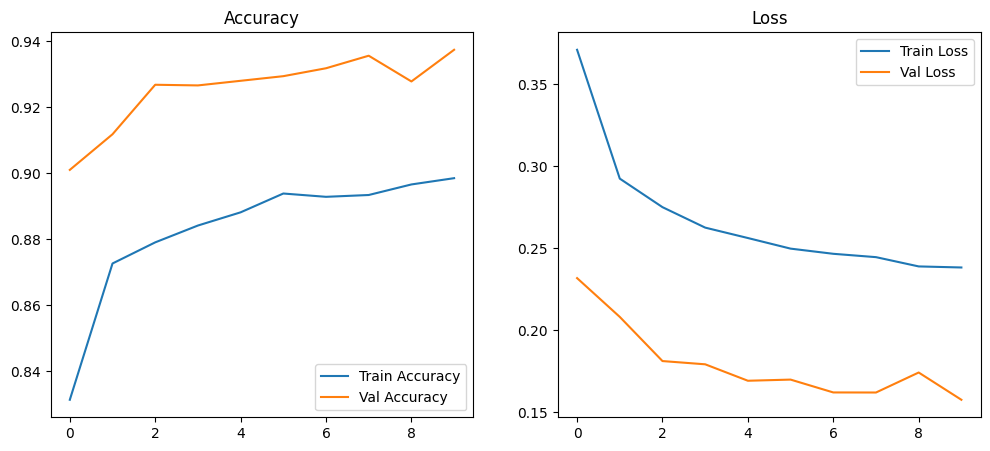

In [24]:
### Plot Training Accuracy and Loss

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [25]:
### Fine-Tuning Top Layers

# Unfreeze top layers
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(1e-5),  # Lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 343s 537ms/step - accuracy: 0.9088 - loss: 0.2124 - val_accuracy: 0.9440 - val_loss: 0.1460
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 340s 544ms/step - accuracy: 0.9391 - loss: 0.1492 - val_accuracy: 0.9606 - val_loss: 0.1035
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 332s 532ms/step - accuracy: 0.9508 - loss: 0.1180 - val_accuracy: 0.9656 - val_loss: 0.0963
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 327s 523ms/step - accuracy: 0.9555 - loss: 0.1071 - val_accuracy: 0.9654 - val_loss: 0.0917
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 325s 520ms/step - accuracy: 0.9614 - loss: 0.1014 - val_accuracy: 0.9690 - val_loss: 0.0824


In [26]:
### Evaluate Model

# Predict on validation set
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
pred_labels = (preds > 0.5).astype(int)

# True labels
true_labels = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(true_labels, pred_labels, target_names=['Cat','Dog'])
print("Classification Report:\n", cr)

157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 187ms/step
Confusion Matrix:
 [[1247 1253]
 [1232 1268]]
Classification Report:
               precision    recall  f1-score   support

         Cat       0.50      0.50      0.50      2500
         Dog       0.50      0.51      0.51      2500

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.50      0.50      0.50      5000



In [36]:
### Check dataset split

import os

print("Train Cats:", len(os.listdir("/content/train/Cat")))
print("Train Dogs:", len(os.listdir("/content/train/Dog")))
print("Val Cats:", len(os.listdir("/content/val/Cat")))
print("Val Dogs:", len(os.listdir("/content/val/Dog")))

Train Cats: 9999
Train Dogs: 9999
Val Cats: 2500
Val Dogs: 2500


In [37]:
### Use Transfer Learning (Recommended)

"""Instead of custom CNN, try MobileNetV2:"""
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Image Data Generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "/content/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    "/content/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Base Model (pre-trained MobileNetV2)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze pre-trained layers

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
preds = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=preds)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Train
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

# Save in new format
model.save("cats_vs_dogs_mobilenet.keras")

Found 19998 images belonging to 4 classes.
Found 5000 images belonging to 4 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


227/625 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.9181 - loss: 0.2323

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 131ms/step - accuracy: 0.9480 - loss: 0.1513 - val_accuracy: 0.9824 - val_loss: 0.0509
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.9817 - loss: 0.0533 - val_accuracy: 0.9832 - val_loss: 0.0456
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.9834 - loss: 0.0444 - val_accuracy: 0.9836 - val_loss: 0.0465
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.9841 - loss: 0.0450 - val_accuracy: 0.9844 - val_loss: 0.0463
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.9849 - loss: 0.0397 - val_accuracy: 0.9846 - val_loss: 0.0440


In [38]:
### Evaluate properly on validation set

val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.9842 - loss: 0.0433
Validation Accuracy: 0.9846, Loss: 0.0440


In [41]:
import os

cat_images = os.listdir("/content/val/Cat")
print("Total Cats in val:", len(cat_images))
print("First 5 Cats:", cat_images[:5])

dog_images = os.listdir("/content/val/Dog")
print("Total Dogs in val:", len(dog_images))
print("First 5 Dogs:", dog_images[:5])

Total Cats in val: 2500
First 5 Cats: ['12144.jpg', '9637.jpg', '488.jpg', '4778.jpg', '2050.jpg']
Total Dogs in val: 2500
First 5 Dogs: ['9637.jpg', '2050.jpg', '74.jpg', '233.jpg', '4080.jpg']


In [43]:
# Example test on a Cat image
predict_image("/content/val/Cat/12144.jpg")

# Example test on a Dog image
predict_image("/content/val/Dog/74.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predicted: Cat (1.0000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted: Dog (0.9983)


In [44]:
import random

# Random Cat test
cat_file = random.choice(cat_images)
predict_image(f"/content/val/Cat/{cat_file}")

# Random Dog test
dog_file = random.choice(dog_images)
predict_image(f"/content/val/Dog/{dog_file}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted: Cat (0.9998)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted: Dog (0.9981)


In [50]:
# Save
model.save("cat_dog_model.keras")

# Reload
from keras.models import load_model
loaded_model = load_model("cat_dog_model.keras")